In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
train_dir='small/train/'
validation_dir='small/validation/'
test_dir='small/test/'

In [3]:
def load_dataset(path, batch_size=1, shuffle=False, size=[224,224]):
    data_path = path
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transforms.Compose([transforms.Resize(size), transforms.ToTensor()])
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=shuffle
    )
    return train_loader

In [4]:
train_loader = load_dataset('small/train/', batch_size=512, size=[224,224])

In [5]:
len(train_loader)

1

In [6]:
test_loader = load_dataset('small/test/', batch_size=256, size=[224,224])

In [7]:
len(test_loader)

1

In [8]:
val_loader = load_dataset('small/validation/', batch_size=256, size=[224,224])

In [9]:
len(val_loader)

1

In [10]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)

In [11]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [12]:
class ModelBottom(nn.Module):
    def __init__(self, original_model):
        super(ModelBottom, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        
    def forward(self, x):
        x = self.features(x)
        return x

In [13]:
resnet_avgpool = ModelBottom(resnet18)

In [60]:
with torch.no_grad():
    for images, labels in train_loader:
        outputs = resnet_avgpool(images)
        outputs = outputs.reshape(outputs.size(0), outputs.size(1))

In [61]:
labels_train = labels
outputs_train = outputs

In [58]:
with torch.no_grad():
    for images, labels in test_loader:
        outputs = resnet_avgpool(images)
        outputs = outputs.reshape(outputs.size(0), outputs.size(1))

In [59]:
labels_test = labels
outputs_test = outputs

In [62]:
with torch.no_grad():
    for images, labels in val_loader:
        outputs = resnet_avgpool(images)
        outputs = outputs.reshape(outputs.size(0), outputs.size(1))

In [63]:
labels_val = labels
outputs_val = outputs

In [64]:
outputs_train = outputs_train.numpy()
labels_train = labels_train.numpy()

outputs_test = outputs_test.numpy()
labels_test = labels_test.numpy()

outputs_val = outputs_val.numpy()
labels_val = labels_val.numpy()

In [65]:
from sklearn.neighbors import KNeighborsClassifier

In [97]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(outputs_train, labels_train)

y_train_predict = knn.predict(outputs_train)
y_val_predict = knn.predict(outputs_val)

err_train = np.mean(labels_train != y_train_predict)
err_val  = np.mean(labels_val  != y_val_predict)

print(err_train, err_val)

0.0234375 0.0234375


In [70]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(outputs_train, labels_train)

err_train = np.mean(labels_train != svc.predict(outputs_train))
err_val  = np.mean(labels_val  != svc.predict(outputs_val))

print(err_train, err_val)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.0 0.015625


In [102]:
from sklearn.model_selection import GridSearchCV
Cs = 10.**np.arange(-3, 3)
gamma_array = 10.**np.arange(-3, 3)
svc = SVC()
grid = GridSearchCV(svc, param_grid = {'C': Cs, 'gamma': gamma_array})
grid.fit(outputs_train, labels_train)

best_cv_err = 1 - grid.best_score_
best_C = grid.best_estimator_.C
print(best_cv_err, best_C)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.025390625 1.0


In [103]:
svc = SVC(C=1)
svc.fit(outputs_train, labels_train)

err_train = np.mean(labels_train != svc.predict(outputs_train))
err_val  = np.mean(labels_val  != svc.predict(outputs_val))

print(err_train, err_val)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.0 0.015625


In [87]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators = 100, min_samples_split = 3)
rf.fit(outputs_train, labels_train)

err_train = np.mean(labels_train != rf.predict(outputs_train))
err_val  = np.mean(labels_val  != rf.predict(outputs_val))

print(err_train, err_val)

0.0 0.0390625


In [86]:
ert = ensemble.ExtraTreesClassifier(n_estimators = 100).fit(outputs_train, labels_train)

err_train = np.mean(labels_train != ert.predict(outputs_train))
err_val  = np.mean(labels_val  != ert.predict(outputs_val))

print(err_train, err_val)

0.0 0.0234375


In [105]:
range_ = np.arange(1,200,5)
range_

array([  1,   6,  11,  16,  21,  26,  31,  36,  41,  46,  51,  56,  61,
        66,  71,  76,  81,  86,  91,  96, 101, 106, 111, 116, 121, 126,
       131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191,
       196])

In [106]:
test_err = []
train_err = []
oob_err = []
for r in range_:
    mlp_model = ensemble.ExtraTreesClassifier(n_estimators = r, n_jobs=-1,)
    mlp_model.fit(outputs_train, labels_train)

    y_train_pred = mlp_model.predict(outputs_train)
    y_test_pred = mlp_model.predict(outputs_val)
    train_err.append(np.mean(labels_train != y_train_pred))
    test_err.append(np.mean(labels_val != y_test_pred))

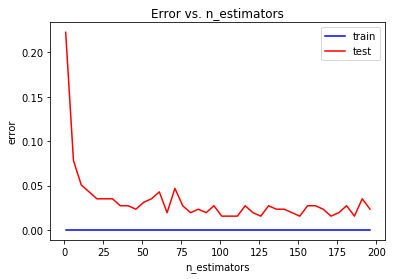

In [108]:
plt.plot(range_, train_err, 'b', label = 'train')
plt.plot(range_, test_err, 'r', label = 'test')
plt.title('Error vs. n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('error')
plt.legend()
pass

In [109]:
print("Минимальная ошибка на тренировочной:", np.min(train_err))
print("Минимальная ошибка на тестовой:", np.min(test_err))
r = range_[test_err == np.min(test_err)]
print("Best 'n_estimators' for Test: ", r)
r = range_[train_err == np.min(train_err)]
print("Best 'n_estimators' for Train: ", r)

Минимальная ошибка на тренировочной: 0.0
Минимальная ошибка на тестовой: 0.015625
Best 'n_estimators' for Test:  [101 106 111 126 151 171 186]
Best 'n_estimators' for Train:  [  1   6  11  16  21  26  31  36  41  46  51  56  61  66  71  76  81  86
  91  96 101 106 111 116 121 126 131 136 141 146 151 156 161 166 171 176
 181 186 191 196]


In [85]:
ada = ensemble.AdaBoostClassifier(n_estimators = 100)
ada.fit(outputs_train, labels_train)

err_train = np.mean(labels_train != ada.predict(outputs_train))
err_val = np.mean(labels_val != ada.predict(outputs_val))

print(err_train, err_val)

0.0 0.03125


In [110]:
range_ = np.arange(1,200,5)
range_

array([  1,   6,  11,  16,  21,  26,  31,  36,  41,  46,  51,  56,  61,
        66,  71,  76,  81,  86,  91,  96, 101, 106, 111, 116, 121, 126,
       131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191,
       196])

In [111]:
test_err = []
train_err = []
for r in range_:
    mlp_model = ensemble.AdaBoostClassifier(n_estimators = r)
    mlp_model.fit(outputs_train, labels_train)

    y_train_pred = mlp_model.predict(outputs_train)
    y_test_pred = mlp_model.predict(outputs_val)
    train_err.append(np.mean(labels_train != y_train_pred))
    test_err.append(np.mean(labels_val != y_test_pred))

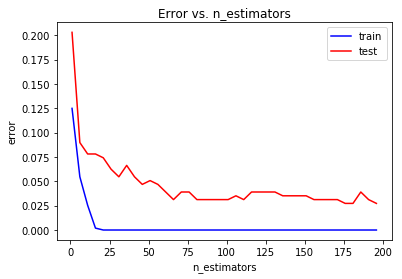

In [112]:
plt.plot(range_, train_err, 'b', label = 'train')
plt.plot(range_, test_err, 'r', label = 'test')
plt.title('Error vs. n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('error')
plt.legend()
pass

In [113]:
print("Минимальная ошибка на тренировочной:", np.min(train_err))
print("Минимальная ошибка на тестовой:", np.min(test_err))
r = range_[test_err == np.min(test_err)]
print("Best 'n_estimators' for Test: ", r)
r = range_[train_err == np.min(train_err)]
print("Best 'n_estimators' for Train: ", r)

Минимальная ошибка на тренировочной: 0.0
Минимальная ошибка на тестовой: 0.02734375
Best 'n_estimators' for Test:  [176 181 196]
Best 'n_estimators' for Train:  [ 21  26  31  36  41  46  51  56  61  66  71  76  81  86  91  96 101 106
 111 116 121 126 131 136 141 146 151 156 161 166 171 176 181 186 191 196]


In [84]:
gbt = ensemble.GradientBoostingClassifier(n_estimators = 100)
gbt.fit(outputs_train, labels_train)

err_train = np.mean(labels_train != gbt.predict(outputs_train))
err_val = np.mean(labels_val != gbt.predict(outputs_val))

print(err_train, err_val)

0.0 0.0390625


In [114]:
range_ = np.arange(1,400,10)
range_

array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
       131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251,
       261, 271, 281, 291, 301, 311, 321, 331, 341, 351, 361, 371, 381,
       391])

In [115]:
test_err = []
train_err = []
for r in range_:
    mlp_model = ensemble.GradientBoostingClassifier(n_estimators = r)
    mlp_model.fit(outputs_train, labels_train)

    y_train_pred = mlp_model.predict(outputs_train)
    y_test_pred = mlp_model.predict(outputs_val)
    train_err.append(np.mean(labels_train != y_train_pred))
    test_err.append(np.mean(labels_val != y_test_pred))

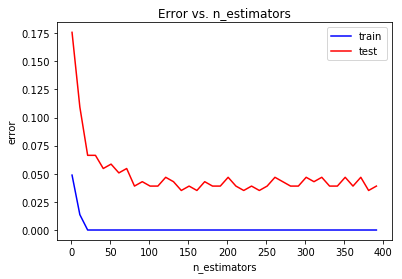

In [116]:
plt.plot(range_, train_err, 'b', label = 'train')
plt.plot(range_, test_err, 'r', label = 'test')
plt.title('Error vs. n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('error')
plt.legend()
pass

In [117]:
print("Минимальная ошибка на тренировочной:", np.min(train_err))
print("Минимальная ошибка на тестовой:", np.min(test_err))
r = range_[test_err == np.min(test_err)]
print("Best 'n_estimators' for Test: ", r)
r = range_[train_err == np.min(train_err)]
print("Best 'n_estimators' for Train: ", r)

Минимальная ошибка на тренировочной: 0.0
Минимальная ошибка на тестовой: 0.03515625
Best 'n_estimators' for Test:  [141 161 221 241 381]
Best 'n_estimators' for Train:  [ 21  31  41  51  61  71  81  91 101 111 121 131 141 151 161 171 181 191
 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371
 381 391]
